In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import scipy.linalg as sc

import warnings as w
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, InitExponentialSmoothing, AdaptiveExponentialSmoothing

%matplotlib inline

In [2]:
def adaptive_selection(x, h, params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar> - forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    x_tr, x_ts = x[:x.shape[0] * 2 // 3], x[x.shape[0] * 2 // 3:]
    
    # base algs Forecasts
    base_algs = params['base_alg_params']
    
    FORECAST_BA = np.empty(( len(base_algs), len(x) + h ))
    FORECAST_BA[:] = np.nan
    
    E = np.empty(FORECAST_BA.shape[1])
    E[:] = np.nan
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for n, base_alg in enumerate(base_algs):
        FORECAST_BA[n] = eval(base_alg['base_alg'])(x, h, base_alg['base_algs_params'])
        
    # internal params of composition
    gamma, eps = params['gamma'], params['eps']
    
    if not(0 <= gamma <= 1):
        w.warn('Gamma must be in [0, 1]')
        return FORECAST
    
    for t in range(len(x)):
        if not( np.isnan(x[t]) or np.isnan(FORECAST_BA[:, t]).any() ):
            #e1 = # прогноз мета-лернера по каждому базовому алгоритму
            E[t] = abs( x[t] - FORECAST_BA[:, t] )
            
            #e1 = gamma * np.abs(FORECAST_BA[:, t] - x[t]) + (1 - gamma) * e1    
            #select = e1 <= (e1.min() + eps)
            #if select.any():
            #    y_t = FORECAST_BA[select, t].mean()
        #E[t + h] = y_t
    
        
#         TODO: перестроение (дообучение) мета-лернера на каждом шаге ???
    return FORECAST

In [3]:
x = np.arange(10)
x.nonzero()

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),)

# Define base algorithms

In [4]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},
#                 {'base_alg':'TheilWageSmoothing', 'base_algs_params':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [5]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

InitExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])


In [6]:
# Read data (time series)
#ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names = ['Timestamp']
ts = ts.sort_index() # sort index

In [7]:
# Define forecast perameters
h = 1 # horizon forecast

# structure of forecasts
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)
FRC_TS = dict()

In [8]:
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []

for cntr in ts.columns:
    ser = ts[cntr]
    tr, v, tst = ser[:1000], ser[1000:1200], ser[1200:]
    X_train.append(tr)
    X_val.append(v)
    X_test.append(tst)
    
    FORECAST_BA = np.empty(( len(base_algs), len(ser) + h ))
    FORECAST_BA[:] = np.nan
    
    for n, base_alg in enumerate(base_algs):
        FORECAST_BA[n] = eval(base_alg['base_alg'])(ser, h, base_alg['base_algs_params'])
        
    Y_train.append(FORECAST_BA[:, :1000])
    Y_val.append(FORECAST_BA[:, 1000:1200])
    Y_test.append(FORECAST_BA[:, 1200:])

In [9]:
k = 3
x = np.arange(7)
sc.hankel(x[:-(k-1)], [-1]+list(x[-(k-1):]) )

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

In [10]:
k = 10
for x, y in [(X_train, Y_train), (X_val, Y_val), (X_test, Y_test)]:
    for i in range(len(x)):
        x[i] = sc.hankel(x[i][:-(k-1)], [-1]+list(x[i][-(k-1):]) )[:-h, :]
        y[i] = y[i][0, k-1+h:]
        print(x[i].shape, y[i].shape)
X_train, X_val, X_test = np.vstack(X_train), np.vstack(X_val), np.vstack(X_test)
Y_train, Y_val, Y_test = np.vstack(Y_train).flatten(), np.vstack(Y_val).flatten(), np.vstack(Y_test).flatten()

(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(990, 10) (990,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(190, 10) (190,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)
(302, 10) (303,)


In [11]:
X_train.shape, X_val.shape, X_test.shape

((10890, 10), (2090, 10), (3322, 10))

In [12]:
Y_train.shape, Y_val.shape, Y_test.shape

((10890,), (2090,), (3333,))

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
rf = RandomForestRegressor

In [74]:
lr = LinearRegression()

In [75]:
lr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
lr.

In [98]:
# run Adaptive Selection
gamma = 0.01
eps = 1.0
for cntr in ts.columns:
    print(ts[cntr].shape)
    frc_ts[cntr] = adaptive_selection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'base_alg_params':base_algs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)
(1512,)


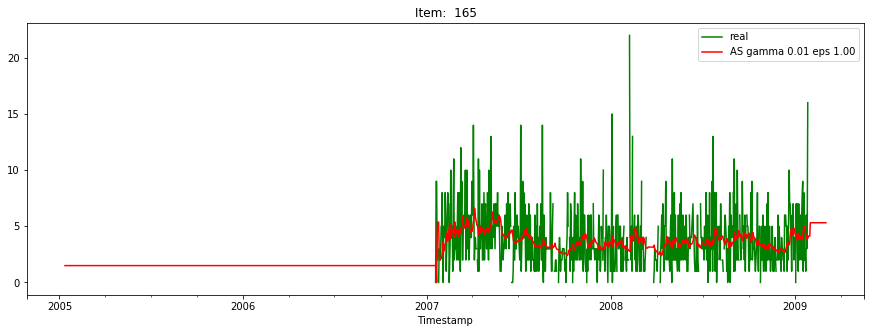

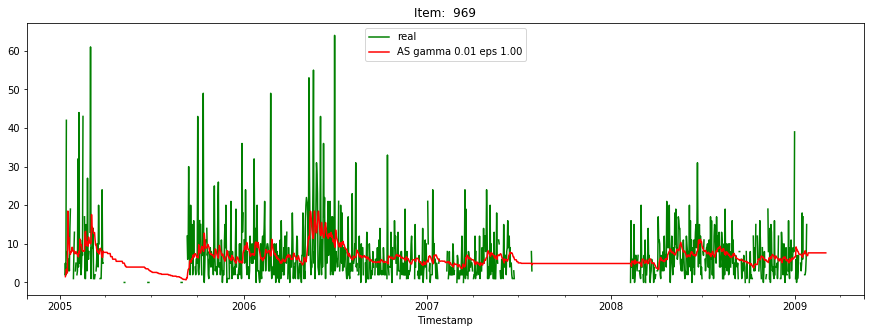

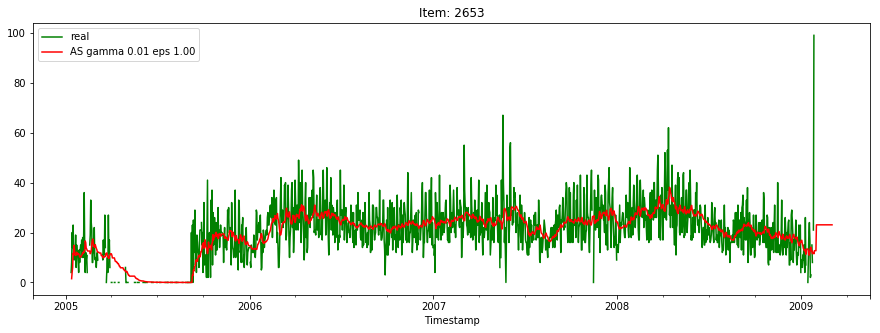

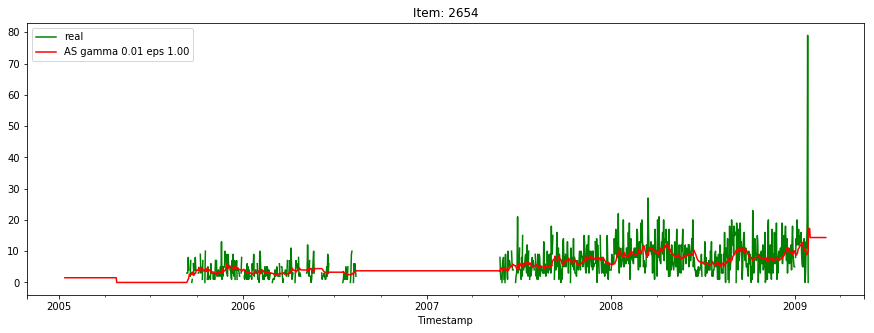

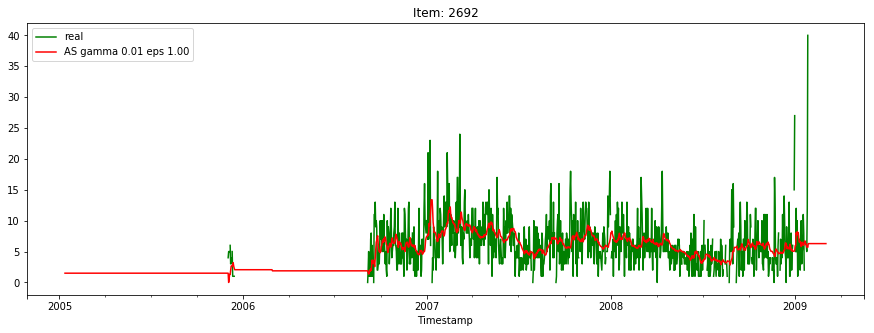

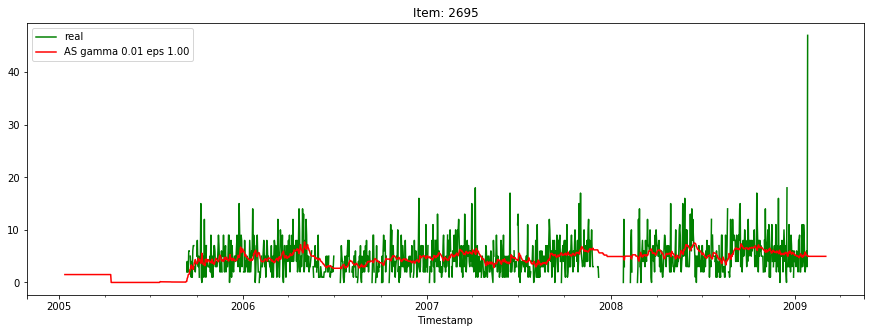

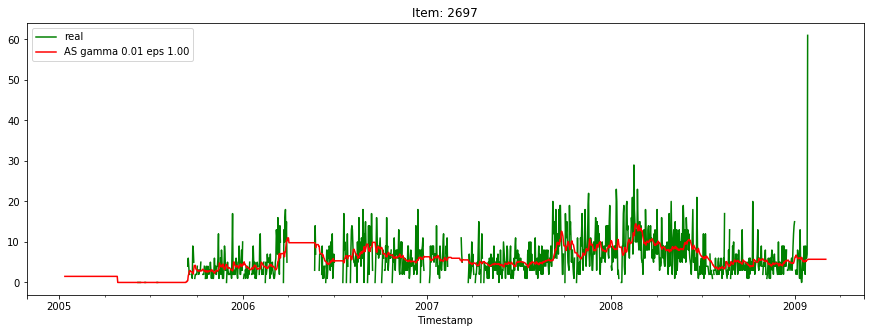

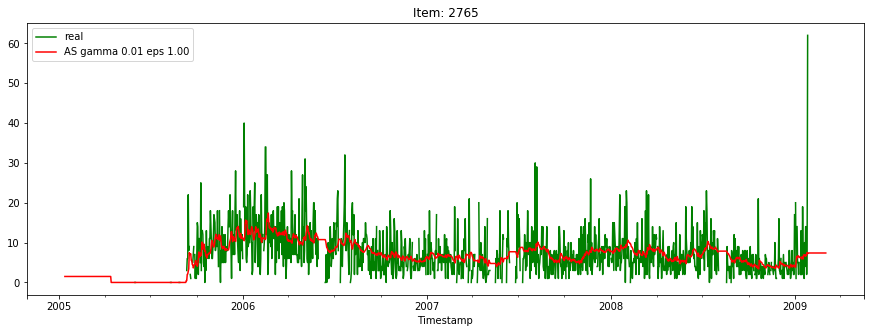

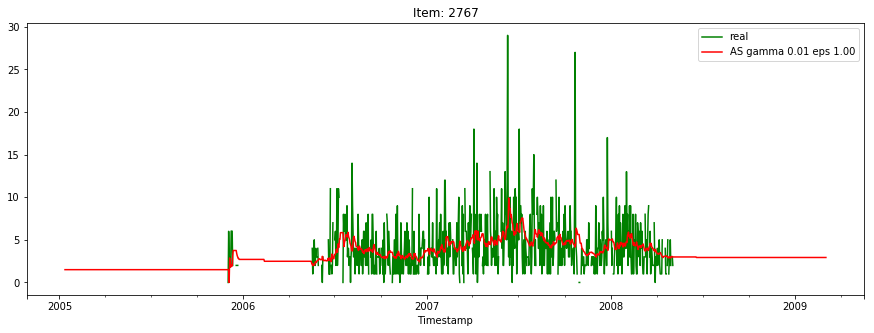

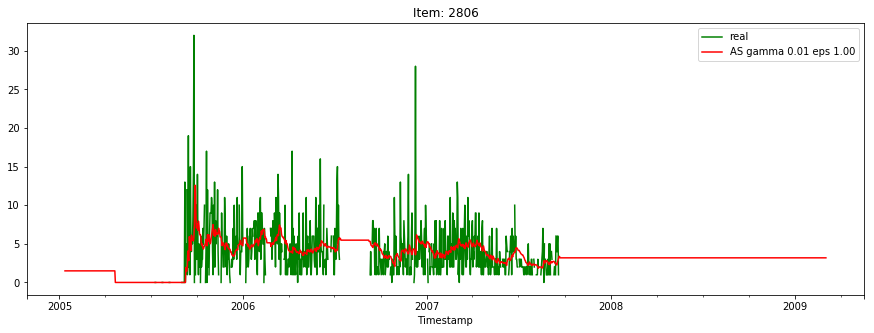

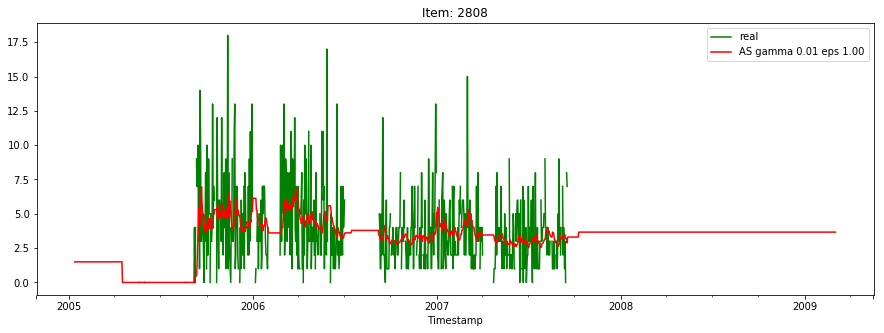

In [99]:
# draw forecast of Adaprive Selection
alg_name = 'AS gamma 0.01 eps 1.00'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()

In [ ]:
алгоритм - это уже подобранные параметры модели (отличие модели от алгоритма)
модель - рандом форест, алгоритм - сам лес

один алгоритм - на все временные ряды, 1000 - трейн, 200 валидация, 300 тест

# Adaptive composition

In [4]:
def adaptive_composition(x, h, params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # base algs Forecasts     
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[ba] = eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_algs_params'])")
    
    # internal params of composition
    gamma = params['gamma']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.array(np.ones(N))  # initialization of errors of base algorithms 
    weights = np.array(np.zeros(N))
    
    y=1.5
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            'TODO: check this code'
            if t>= h:
                e1 = gamma*np.abs(x[t]-FORECAST_BA.transpose()[t])+(1-gamma)*e1
           
                # select best algorithm at the moment t
                w_best = 'TODO: calculate weights of base algorithms'
                
#               Calculate forecast of the composition
                y = FORECAST_BA.transpose()[t].dot(weights)
                # else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [12]:
# run (build forecast) Adaptive Composition
gamma=0.01

for cntr in ts.columns:
    frc_ts[cntr]= adaptive_composition(ts[cntr],h, {'gamma':gamma, 'base_alg_params':base_algs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

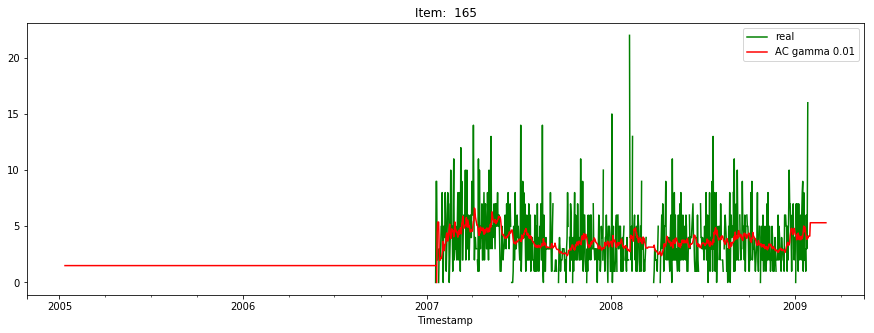

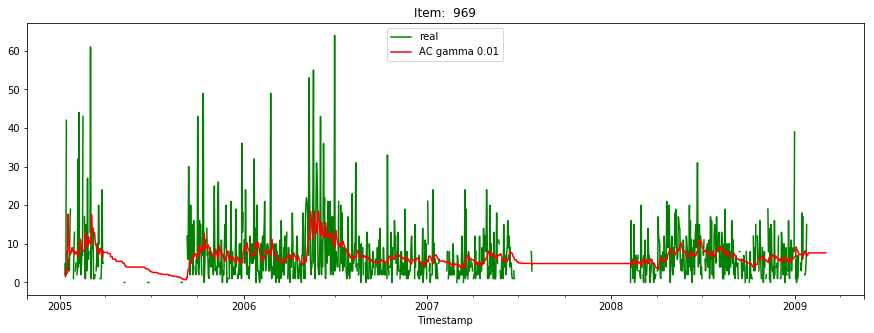

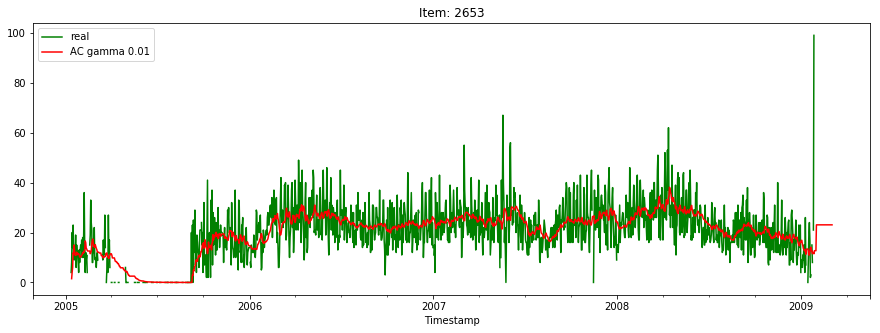

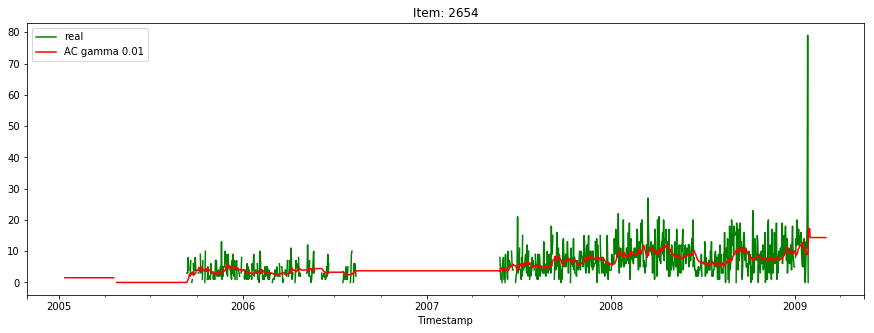

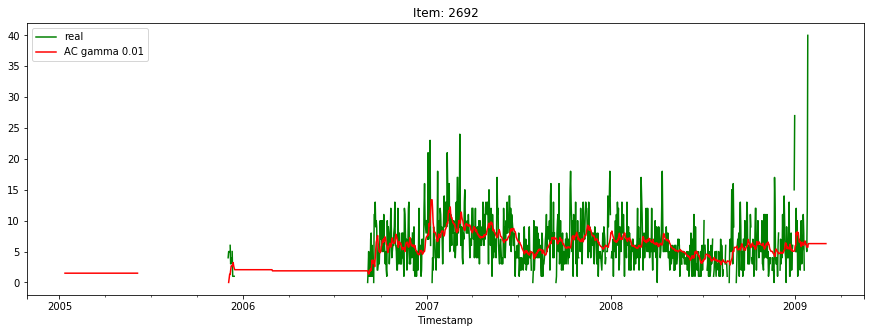

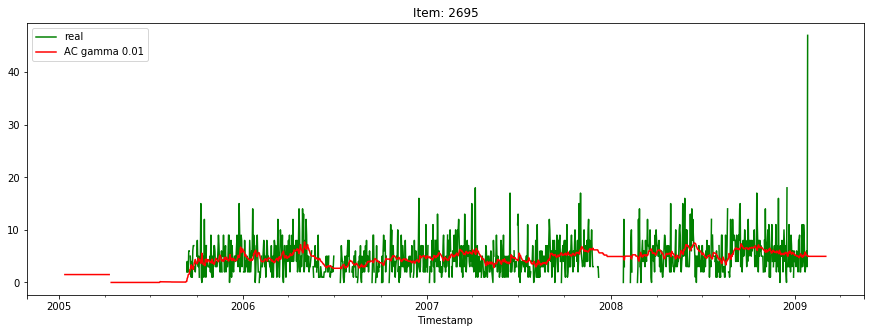

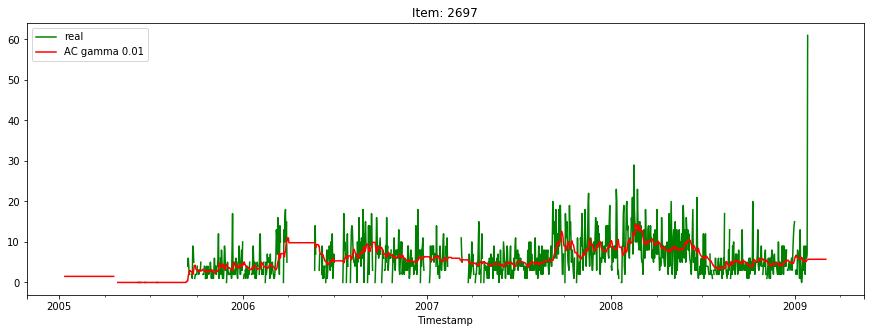

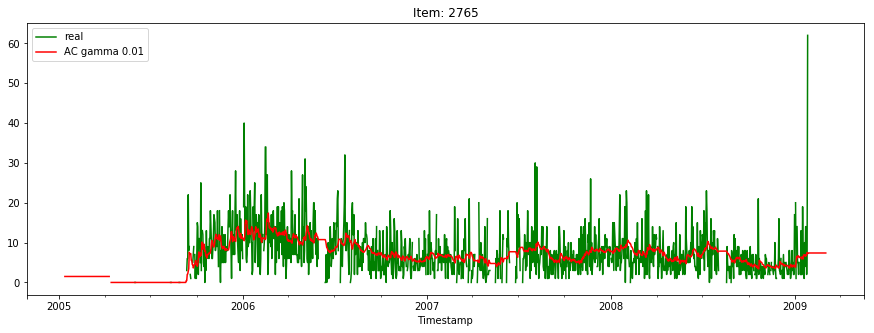

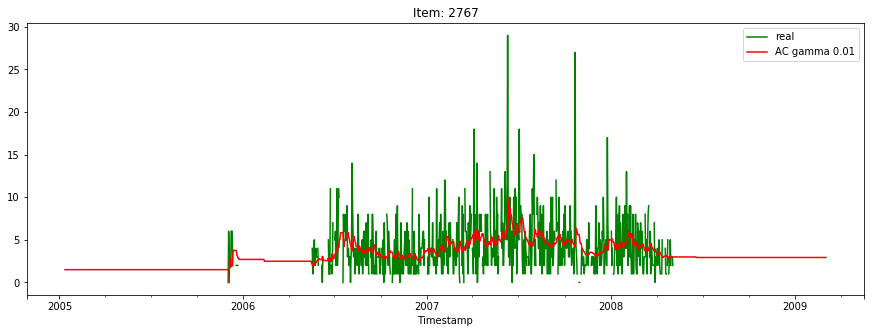

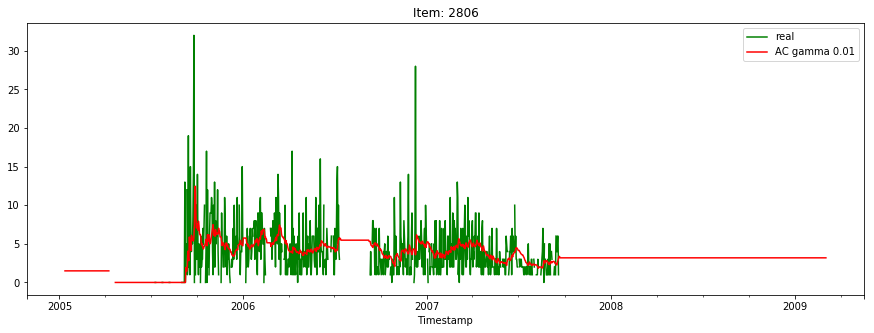

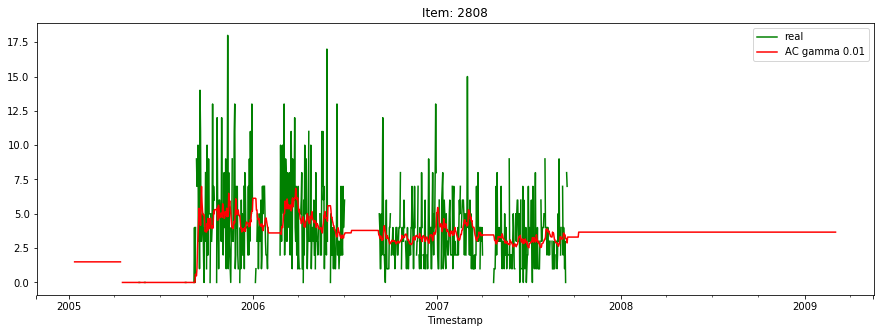

In [13]:
# draw forecast of Adaptive Selection
alg_name = 'AC gamma 0.01'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()

# Aggregating Algorithm
** Question:**
* What is aggregating algorithm?
* What is a mixable game?
* Descibe parameters of AA:
    - $\beta$ - parametr of mixability
    - $S(g)$ - substitution function
    - $p_j$ - initial distribution of base algorithms
* Write down theoretical boundary for AA

In [ ]:
def aa_composition(x, h, params):
'''
Parameters
x <array> - time series
h <integer scalar>- forecasting delay
params <dict> - dictionary with 
    beta <scalar in [0,1]> - mixability parameter 
    weights <array in [0,1]> - initial weights of base_algs
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
'''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    # base algs Forecasts     
    base_algs = params.base_algs
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[BA]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    
    # internal params of composition
    beta = params['beta']
    weights = params['weights']
    
    if beta>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if beta<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

           
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                weights = 
           
                
#               Calculate forecast of the composition
                y = 'Substitution function'
                
         else:
            y = 'Substitution function'
            
        FORECAST[t+h] = y
    return FORECAST

In [ ]:
# run (build forecast) Aggregating Algorithm

h =1 # forecast horizon

# define base algorithm
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_alg_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_alg_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

for cntr in ts.columns:
    frc_ts[cntr]= aa_composition(ts[cntr],h, {'beta':0.9, 'weiths': np.array([0.5,0.5]), 'base_alg_params':base_algs})
FRC_TS['AA beta %.2f' % (beta)] = frc_ts

In [ ]:
# draw forecast of Aggregating Algorithm
alg_name = 'AA beta 0.90'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()